In [4]:
import parametrization as param
from CentralStreamingModel.utils.read_probabilities import VD, VD_los
from CentralStreamingModel.projection import generating_moments
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps
from scipy.interpolate import interp1d, interp2d
import seaborn as sns
from CentralStreamingModel.moments import moments2model, read
from scipy.interpolate import UnivariateSpline
from halotools.mock_observables import tpcf_multipole

sns.set_context('talk')

In [5]:
n_boxes = 14
boxsize = 2000
snapshot = 20
rm = read.Read_Mean(n_boxes, boxsize, snapshot)

In [6]:
parameters = [r'$m_r$',r'$c_r$',r'$c_t$']

In [7]:
ex = generating_moments.Expectations(rm.r, rm.v_r, rm.v_t,
                                     rm.jointpdf_rt)


In [80]:
s = np.arange(0.,50.,1)
mu = np.linspace(0.,1,60)


In [9]:
moments_projected = generating_moments.project(ex, rm.r_perp,
                                    rm.r_parallel)

In [10]:
gaussian = moments2model.Model(rm, moments_projected)


In [11]:
gaussian.multipoles(s, mu) # MUST be the same

In [12]:
m_r = ex.moment(1,0)(rm.r)
c_r = ex.central_moment(2,0)(rm.r)
c_t = ex.central_moment(0,2)(rm.r)

## FIT

In [13]:
def fitting_m_r(r, a, b,c,d):
    return a * r**b  + c*r + d

In [14]:
def fitting_m_r(r, a,c,d):
    return a * r**(0.5) + c*r + d

0.18118355530464691


Text(40, -2, '$m_r(r) = A \\sqrt{r} + B r + C$')

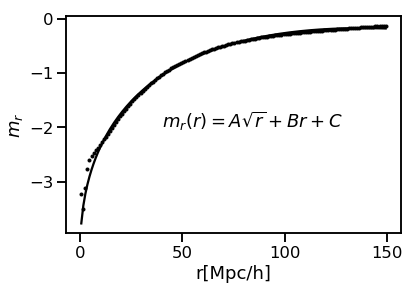

In [171]:
idx = 0

_, chi, popt_m_r = param.plot(fitting_m_r, rm.r, m_r, 
        'black', 'Halos',parameters[idx], limit = 20)
#plt.text(40, -2, r'$\chi^2_\nu $ = %.2f'%chi, fontdict=dict(color='black'))
plt.text(40,-2,r'$m_r(r) = A \sqrt{r} + B r + C$')
#plt.xlim(10,70)

In [16]:
popt_m_r

array([ 0.69643867, -0.02966848, -4.26372462])

In [161]:
def fitting_c(r, a, b,c):
    return a * r**b  + c

2.042857063858118


(0, 30)

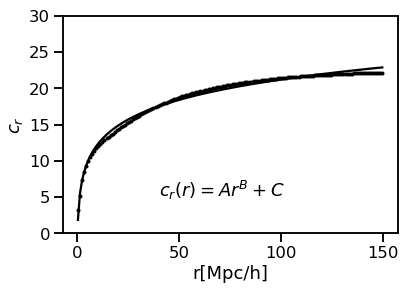

In [173]:
idx = 1

_, chi, popt_c_r = param.plot(fitting_c, rm.r, c_r, 
        'black', 'Halos',parameters[idx], limit = 0)
#plt.text(40, -2, r'$\chi^2_\nu $ = %.2f'%chi, fontdict=dict(color='black'))
plt.text(40,5,r'$c_r(r) = A r^B + C$')

plt.ylim(0,30)

0.9709607993454943


Text(40, 5, '$c_t(r) = A r^B + C$')

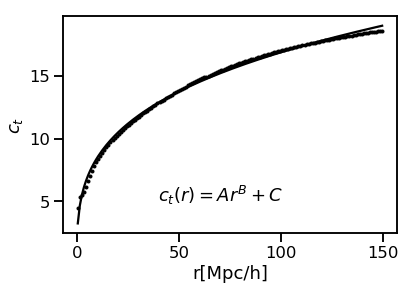

In [176]:
idx = 2

_, chi, popt_c_t = param.plot(fitting_c, rm.r, c_t, 
        'black', 'Halos',parameters[idx], limit = 0)
plt.text(40,5,r'$c_t(r) = A r^B + C$')
#plt.text(40, -2, r'$\chi^2_\nu $ = %.2f'%chi, fontdict=dict(color='black'))

In [25]:
len(rm.r_parallel)

100

In [26]:

moments_reduced = np.zeros((len(rm.r_perp), len(rm.r_parallel), 3))


for i, rper in enumerate(rm.r_perp):                                                                                                   
    for j, rpar in enumerate(rm.r_parallel):                                                                                           

        r_ = np.sqrt(rper**2 + rpar**2)                                                                                             
        mu_value = rpar/r_                                                                                                                


        moments_reduced[i,j, 0] = fitting_m_r(r_, *popt_m_r) * mu_value                                                                                  

        moments_reduced[i,j, 1] = fitting_c(r_, *popt_c_r) * mu_value**2+fitting_c(r_, *popt_c_t) * (1 - mu_value**2) 
#moments_reduced[...,1] = moments_projected[...,1]

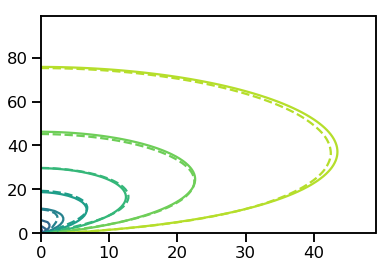

In [27]:
levels = np.linspace(-4., 0., 10)

plt.contour(moments_reduced[...,0].T, levels=levels)
plt.contour(moments_projected[...,0].T, linestyles='dashed', levels=levels)

In [28]:
gaussian_reduced = moments2model.Model(rm, moments_reduced)

In [29]:
gaussian_reduced.multipoles(s, mu) # MUST be the same

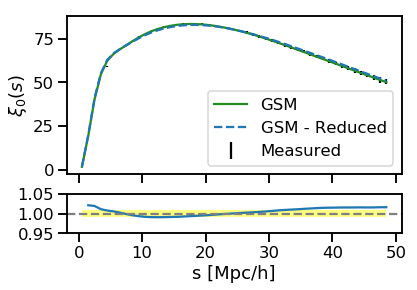

In [180]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})

ax1.errorbar(rm.s_c, rm.s_c * rm.s_c * rm.mono.mean,
            yerr =  rm.s_c * rm.s_c * rm.mono.std, linestyle = '',
            color = 'black', label = 'Measured')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * gaussian.mono,
        color = 'forestgreen', label = 'GSM')
ax1.plot(gaussian_reduced.s_c, 
         gaussian_reduced.s_c * gaussian_reduced.s_c * gaussian_reduced.mono,
        label = 'GSM - Reduced', linestyle='dashed')

ax2.plot(gaussian_reduced.s_c[1:], gaussian_reduced.mono[1:]/gaussian.mono[1:])
ax2.axhline(y = 1., linestyle='dashed', color='gray')
ax1.set_ylabel(r'$\xi_0 (s)$')
ax2.set_xlabel(r's [Mpc/h]')
ax2.fill_between(gaussian.s_c,0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
ax2.set_ylim(0.95,1.05)
ax1.legend()


Text(0.5, 0, 's [Mpc/h]')

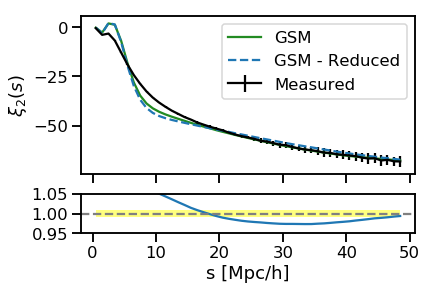

In [185]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})

ax1.errorbar(rm.s_c, rm.s_c * rm.s_c * rm.quad.mean,
            yerr =  rm.s_c * rm.s_c * rm.quad.std,
            color = 'black', label = 'Measured')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * gaussian.quad,
         color = 'forestgreen', label = 'GSM')
ax1.plot(gaussian_reduced.s_c, gaussian_reduced.s_c * gaussian_reduced.s_c * gaussian_reduced.quad,
                label = 'GSM - Reduced', linestyle='dashed')

ax1.legend()
ax2.plot(gaussian_reduced.s_c[1:], gaussian_reduced.quad[1:]/gaussian.quad[1:])
ax2.axhline(y = 1., linestyle='dashed', color='gray')
ax2.fill_between(gaussian.s_c,0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
ax2.set_ylim(0.95,1.05)

ax1.set_ylabel(r'$\xi_2 (s)$')
ax2.set_xlabel(r's [Mpc/h]')

Text(0.5, 0, 's [Mpc/h]')

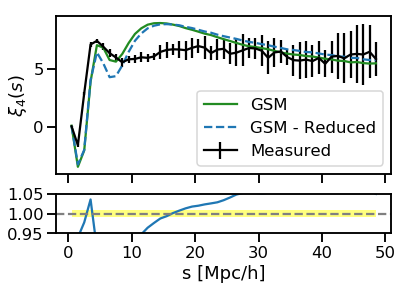

In [188]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})

ax1.errorbar(rm.s_c, rm.s_c * rm.s_c * rm.hexa.mean,
            yerr =  rm.s_c * rm.s_c * rm.hexa.std,
            color = 'black', label = 'Measured')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * gaussian.hexa,
         color = 'forestgreen', label = 'GSM')
ax1.plot(gaussian_reduced.s_c, gaussian_reduced.s_c * gaussian_reduced.s_c * gaussian_reduced.hexa,
                label = 'GSM - Reduced', linestyle='dashed')
ax1.legend()

ax2.plot(gaussian_reduced.s_c[1:], gaussian_reduced.hexa[1:]/gaussian.hexa[1:])
ax2.axhline(y = 1., linestyle='dashed', color='gray')
ax2.fill_between(gaussian.s_c,0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
ax2.set_ylim(0.95,1.05)

ax1.set_ylabel(r'$\xi_4 (s)$')
ax2.set_xlabel(r's [Mpc/h]')

In [44]:
# TEST INTEGRAND APPROXIMATION

def dm_ds(s, popt_m_r):
    a, b, c = popt_m_r
    return 0.5 * a/np.sqrt(s) + b


def ddm_dds(s, popt_m_r):
    a, b, c = popt_m_r
    return -1./4. * a / s**(3./2.)

def dmu_dsparallel(s, s_perp):
    
    return s_perp**2/s**3

def ds_dsparallel(mu):
    return mu

def dm_dsparallel(s_parallel, s_perp, popt_m_r):

    s = np.sqrt(s_perp**2 + s_parallel**2)
    mu = s_parallel/s
        
    return dmu_dsparallel(s, s_perp) * fitting_m_r(s, *popt_m_r) + mu * ds_dsparallel(mu) * dm_ds(s, popt_m_r)
    


In [112]:
def m2(s_parallel, s, popt_c_r, popt_c_t):
    mu = s_parallel/s
    
    return  mu**2 * fitting_c(s, *popt_c_r) +\
    (1 - mu**2) * fitting_c(s, *popt_c_t) + (fitting_m_r(s, *popt_m_r))**2

def dc_ds(s, popt_c):
    a, b, c = popt_c
    return a * b  * pow(s, b-1)

def dc_dsparallel(s_parallel, s_perp, popt_c_r, popt_c_t):
    s = np.sqrt(s_perp**2 + s_parallel**2)
    mu = s_parallel/s
        
    return 2 * mu * dmu_dsparallel(s, s_perp) * (fitting_c(s, *popt_c_r) - fitting_c(s, *popt_c_t)) +\
    mu**2  * ds_dsparallel(mu) * dc_ds(s, popt_c_r) + (1 - mu**2) * ds_dsparallel(mu) *  dc_ds(s, popt_c_t)

def dm2_dsparallel(s_parallel, s_perp, popt_m_r, popt_c_r, popt_c_t):
    s = np.sqrt(s_perp**2 + s_parallel**2)
    mu = s_parallel/s
    
    return dc_dsparallel(s_parallel, s_perp, popt_c_r, popt_c_t) +\
    2 * fitting_m_r(s, *popt_m_r) *dm_dsparallel(s_parallel, s_perp, popt_m_r)
    
    
def ddc_dds(s, popt_c):
    a, b, c = popt_c
    return a * b * (b - 1) * pow(s, b-2)

def ddmu_ddsparallel(s, s_parallel):
    
    return s_parallel * (3 * s_parallel**2/s**5 - 1/s**3) - 2 * s_parallel/s**3

def dds_ddsparallel(s, s_perp):
    return s_perp**2/s**3

def ddc2_ddsparallel(s_parallel, s_perp, popt_c_r, popt_c_t):

    s = np.sqrt(s_perp**2 + s_parallel**2)
    mu = s_parallel/s   
    
    
    return 2 *(fitting_c(s, *popt_c_r) - fitting_c(s, *popt_c_t)) * \
    (dmu_dsparallel(s, s_perp)**2   + mu * ddmu_ddsparallel(s, s_parallel)) + \
    4 * mu * dmu_dsparallel(s, s_perp) * ds_dsparallel(mu) * (dc_ds(s, popt_c_r) - dc_ds(s, popt_c_t)) + \
    mu**2 * dds_ddsparallel(s, s_perp) * dc_ds(s, popt_c_r) + mu**2*ds_dsparallel(mu)**2* ddc_dds(s, popt_c_r) +\
    (1-mu)**2 * dds_ddsparallel(s, s_perp) * dc_ds(s, popt_c_t) +\
    (1-mu)**2*ds_dsparallel(mu)**2* ddc_dds(s, popt_c_t)

    
def ddm_ddsparallel(s_parallel, s_perp, popt_m_r):
    
    s = np.sqrt(s_perp**2 + s_parallel**2)
    mu = s_parallel/s   
    
    return ddmu_ddsparallel(s, s_parallel) * fitting_m_r(s, *popt_m_r) + \
    2 * dmu_dsparallel(s, s_perp) * ds_dsparallel(mu)  * dm_ds(s, popt_m_r) + \
    mu * (dds_ddsparallel(s, s_perp) * dm_ds(s, popt_m_r) + (ds_dsparallel(mu))**2 * ddm_dds(s, popt_m_r))

def ddm2_ddsparallel(s_parallel, s_perp, popt_m_r, popt_c_r, popt_c_t):
    
    s = np.sqrt(s_perp**2 + s_parallel**2)
    mu = s_parallel/s 
    
    return ddc2_ddsparallel(s_parallel, s_perp, popt_c_r, popt_c_t) +\
    2 *(dm_dsparallel(s_parallel, s_perp, popt_m_r))**2 + \
    2 * fitting_m_r(s, *popt_m_r) * ddm_ddsparallel(s_parallel, s_perp, popt_m_r)
    

In [113]:
interp_twopcf = UnivariateSpline(rm.tpcf_dict['r'], rm.tpcf_dict['tpcf'], k = 3, s=0.)

def approximation(order, xi = False):
    approx = np.zeros((len(rm.r_perp), len(rm.r_perp)))
    
    for i, rperp in enumerate(rm.r_perp):
    
        for j, rpar in enumerate(rm.r_perp):

            r = np.sqrt(rperp ** 2 + rpar**2)
            mu_value = rpar/r

            if xi:
                if order == 1:
                    approx[i,j] = ( 1  +  interp_twopcf(r) ) * (1 - dm_dsparallel(rpar, rperp, popt_m_r) ) \
                        - interp_twopcf.derivative(n=1)(r)*ds_dsparallel(mu_value) *fitting_m_r(r, *popt_m_r) \
                        - 1.  
                
                else:
                    
        
                    approx[i,j] = ( 1  +  interp_twopcf(r) ) * (1 - dm_dsparallel(rpar, rperp, popt_m_r)\
                     +  0.5 *  ddm2_ddsparallel(rpar, rperp,popt_m_r, popt_c_r, popt_c_t)) \
                    - interp_twopcf.derivative(n=1)(r)*ds_dsparallel(mu_value) *fitting_m_r(r, *popt_m_r) \


                    + interp_twopcf.derivative(n=1)(r)*ds_dsparallel(mu_value)* dm2_dsparallel(rpar, 
                                                                rperp, popt_m_r, popt_c_r, popt_c_t) \
                    
                    + 0.5 * m2(rpar, r, popt_c_r, popt_c_t)* (
                    interp_twopcf.derivative(n=2)(r) * ds_dsparallel(mu_value)**2 +\
                    dds_ddsparallel(r, rperp)  * interp_twopcf.derivative(n=1)(r) )  \
                    - 1.                
                
            else:
                if order == 1:
                    approx[i,j] = interp_twopcf(r) - dm_dsparallel(rpar, rperp, popt_m_r) #+\
                else:
                    approx[i,j] = interp_twopcf(r) - dm_dsparallel(rpar, rperp, popt_m_r) +\
                        0.5 * ddm2_ddsparallel(rpar, rperp,popt_m_r, popt_c_r, popt_c_t)

    pi_sigma_interpolation =interp2d(rm.r_perp,
                rm.r_perp, approx, kind='linear')
    s_mu_approx = np.zeros((len(gaussian.s_c), len(gaussian.mu_c)))

    for i, s_value in enumerate(gaussian.s_c):
        for j, mu_value in enumerate(gaussian.mu_c):
            r_parallel = mu_value * s_value
            r_perpendicular = np.sqrt(s_value**2 - r_parallel**2)

            s_mu_approx[i,j] = pi_sigma_interpolation(r_parallel,
                                    r_perpendicular)
                        
        
    mono_approx = tpcf_multipole(s_mu_approx, mu, order = 0)
    quad_approx = tpcf_multipole(s_mu_approx, mu, order = 2)
    hexa_approx = tpcf_multipole(s_mu_approx, mu, order = 4)
                        
    return mono_approx, quad_approx, hexa_approx



In [114]:
mono_1, quad_1, hexa_1 = approximation(1, xi = False)
mono_1_xi, quad_1_xi, hexa_1_xi = approximation(1, xi = True)
mono_2, quad_2, hexa_2 = approximation(2, xi = False)
mono_2_xi, quad_2_xi, hexa_2_xi = approximation(2, xi = True)


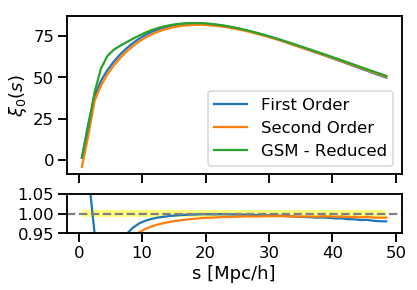

In [189]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})

#ax1.errorbar(rm.s_c, rm.s_c * rm.s_c * rm.mono.mean,
#            yerr =  rm.s_c * rm.s_c * rm.mono.std)
#ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * gaussian.mono)
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * mono_1, label = 'First Order')
#ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * mono_1_xi, label = '1 xi')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * mono_2, label = 'Second Order')
#ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * mono_2_xi, label = '2 xi')

ax1.plot(gaussian_reduced.s_c, gaussian_reduced.s_c * gaussian_reduced.s_c * gaussian_reduced.mono, 
         label = 'GSM - Reduced')

ax2.plot(gaussian_reduced.s_c[1:], mono_1[1:]/gaussian_reduced.mono[1:])
#ax2.plot(gaussian_reduced.s_c[1:], mono_1_xi[1:]/gaussian_reduced.mono[1:])

ax2.plot(gaussian_reduced.s_c[1:], mono_2[1:]/gaussian_reduced.mono[1:])
#ax2.plot(gaussian_reduced.s_c[1:], mono_2_xi[1:]/gaussian_reduced.mono[1:])

ax2.axhline(y = 1., linestyle='dashed', color='gray')
ax1.set_ylabel(r'$\xi_0 (s)$')
ax2.set_xlabel(r's [Mpc/h]')
ax2.fill_between(gaussian.s_c,0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
ax2.set_ylim(0.95,1.05)

ax1.legend()

(0.95, 1.05)

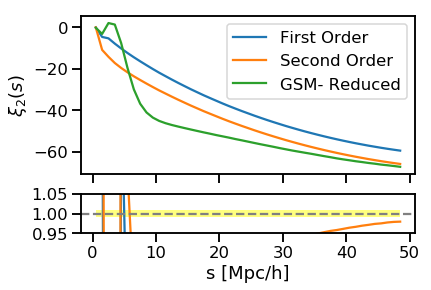

In [190]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})

#ax1.errorbar(rm.s_c, rm.s_c * rm.s_c * rm.mono.mean,
#            yerr =  rm.s_c * rm.s_c * rm.mono.std)
#ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * gaussian.mono)
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * quad_1, label = 'First Order')
#ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * quad_1_xi, label = '1 xi')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * quad_2, label = 'Second Order')
#ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * mono_2_xi, label = '2 xi')

ax1.plot(gaussian_reduced.s_c, gaussian_reduced.s_c * gaussian_reduced.s_c * gaussian_reduced.quad,
         label = 'GSM- Reduced')

ax2.plot(gaussian_reduced.s_c[1:], quad_1[1:]/gaussian_reduced.quad[1:])
#ax2.plot(gaussian_reduced.s_c[1:], quad_1_xi[1:]/gaussian_reduced.quad[1:])

ax2.plot(gaussian_reduced.s_c[1:], quad_2[1:]/gaussian_reduced.quad[1:])
#ax2.plot(gaussian_reduced.s_c[1:], quad_2_xi[1:]/gaussian_reduced.quad[1:])

ax1.legend()
ax2.axhline(y = 1., linestyle='dashed', color='gray')
ax1.set_ylabel(r'$\xi_2 (s)$')
ax2.set_xlabel(r's [Mpc/h]')
ax2.fill_between(gaussian.s_c,0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
ax2.set_ylim(0.95,1.05)

(0.95, 1.05)

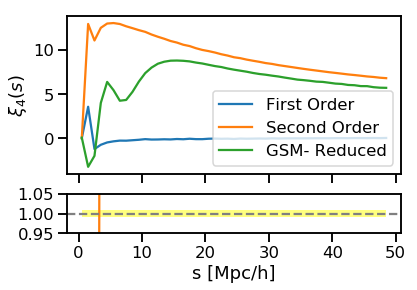

In [191]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})

#ax1.errorbar(rm.s_c, rm.s_c * rm.s_c * rm.mono.mean,
#            yerr =  rm.s_c * rm.s_c * rm.mono.std)
#ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * gaussian.mono)
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * hexa_1, label = 'First Order')
#ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * quad_1_xi, label = '1 xi')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * hexa_2, label = 'Second Order')
#ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * mono_2_xi, label = '2 xi')

ax1.plot(gaussian_reduced.s_c, gaussian_reduced.s_c * gaussian_reduced.s_c * gaussian_reduced.hexa,
         label = 'GSM- Reduced')

ax2.plot(gaussian_reduced.s_c[1:], hexa_1[1:]/gaussian_reduced.hexa[1:])
#ax2.plot(gaussian_reduced.s_c[1:], quad_1_xi[1:]/gaussian_reduced.quad[1:])

ax2.plot(gaussian_reduced.s_c[1:], hexa_2[1:]/gaussian_reduced.hexa[1:])
#ax2.plot(gaussian_reduced.s_c[1:], quad_2_xi[1:]/gaussian_reduced.quad[1:])

ax1.legend()
ax2.axhline(y = 1., linestyle='dashed', color='gray')
ax1.set_ylabel(r'$\xi_4 (s)$')
ax2.set_xlabel(r's [Mpc/h]')
ax2.fill_between(gaussian.s_c,0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
ax2.set_ylim(0.95,1.05)